## Data
1. 2013-2016.csv -- vish uploaded in drive.
2. ct_shape.shp -- The One we used in PUI_HW10 to calculate the area of NYC.
3. Location of Dropin centers are input manually.


In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import pylab as pl
%pylab inline
import rtree
import scipy.stats as stats
# import seaborn
from fiona.crs import from_epsg

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## 1. 311 Homeless Complaints Data

In [9]:
df = pd.read_csv("../Homeless/VYS217/Data_vys217/DHS/311_Service_Requests/311_Homeless_2013_2016.csv")
df = df.loc[:,['Created Date', 'Incident Zip', 'City', 'Borough', 'Latitude', 'Longitude']]
df = df.dropna(subset=['Latitude', 'Longitude'])
#df = df.dropna().shape

C:\Users\Vishwajeet\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#df = pd.read_csv("311_2015.csv")
#df = df.dropna() #important!!! especially for col = Lon & Lat
#print df.shape

# make sure 'Lon-Lat' are numeric variable
type(df.Latitude.values[0])
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Following code is another way to create 'geometry':
# geometry = gpd.GeoSeries([Point(xy) for xy in zip(df.Longitude, df.Latitude)])

gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
# set coordinate system
gdf.crs = {"init": "epsg:4326"}
gdf.head(2)

,Created Date,Incident Zip,City,Borough,Latitude,Longitude,geometry
0,08/24/2016 10:52:00 AM,10023.0,NEW YORK,MANHATTAN,40.769157,-73.982429,POINT (-73.98242917087232 40.76915732305015)
1,08/25/2016 08:36:59 AM,10009.0,NEW YORK,MANHATTAN,40.728159,-73.982956,POINT (-73.98295592150251 40.7281590982977)


## 2. Drop-In Centers Data

#### 24-HOUR DROP-IN CENTERS FOR ADULTS : http://www1.nyc.gov/assets/dhs/downloads/pdf/intake_drop_in_centers.pdf

In [11]:
# Tips: {"Name": [list]}
dropin = gpd.GeoDataFrame({"Name": ['Mainchance'], "Address": ["120 East 32nd St. in East Midtown"], "Zipcode": ["10016"], 
          "geometry": [Point(-73.9814622, 40.7452285)]}, geometry = 'geometry') 
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['The Living Room'] ,"Address": ["800 Barretto St., Bronx"], 
                                "Zipcode": ["10474"], "geometry": [Point(-73.8916751, 40.8168537)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['Olivieri Center'], "Address": ["257 West 30th St. near Penn Station"], 
                                "Zipcode": ["10001"], "geometry": [Point(-73.9966147, 40.7495275)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['The Gathering Place'], "Address": ["2402 Atlantic Ave. in Brooklyn"], 
                                "Zipcode": ["11233"], "geometry": [Point(-73.9075159, 40.6757497)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['Project Hospitality'], "Address": ["25 Central Ave. in Staten Island"], 
                                "Zipcode": ["10301"], "geometry": [Point(-74.0787456, 40.641182)]}, 
                               geometry = 'geometry'))
dropin.crs = {"init": "epsg:4326"}
dropin = dropin.reset_index(drop = True)
dropin

,Address,Name,Zipcode,geometry
0,120 East 32nd St. in East Midtown,Mainchance,10016,POINT (-73.9814622 40.7452285)
1,"800 Barretto St., Bronx",The Living Room,10474,POINT (-73.8916751 40.8168537)
2,257 West 30th St. near Penn Station,Olivieri Center,10001,POINT (-73.9966147 40.7495275)
3,2402 Atlantic Ave. in Brooklyn,The Gathering Place,11233,POINT (-73.90751590000001 40.6757497)
4,25 Central Ave. in Staten Island,Project Hospitality,10301,POINT (-74.07874560000001 40.641182)


## 3. Ring & Buffer Density

### Functions

In [12]:
# 1. ring-buffer
def circles(radius, df):
    '''
    radius: list
    df: df with geometry 'Polygon'
    return: Circles not Rings, eg. b['0.001']
    '''
    b = {}
    for r in radius:
        temp = df.copy()
        temp['geometry'] = temp.buffer(r)
        temp.crs = from_epsg(4326)
        name = str(r) 
        b[name] = temp
    return b 

# 2. sjoin: (Polygon, Points) - counts
def circleSJoin(radius, b, df_points):
    '''
    b: circles (buffer)
    df_points: df with geometry "Points"
    return: Circle not Ring with # of Points in each, eg. b_sjoin['0.001']
    '''
    c_sjoin = {}
    for i, r in enumerate(b):
        name = str(radius[i])
        temp = b[name].copy()
        temp.crs = df_points.crs
        c_sjoin[name] = gpd.sjoin(temp, df_points)
    return c_sjoin 

# 3. ringDensity
def Density(radius, circles, c_sjoin, shape):
    rAreas = {}
    rCounts = {}
    rDesity = {} 
    rCounts_list = []
    rDesity_list = []
    for i in xrange(len(radius)):
        name = str(radius[i])
        if shape == 'ring':
            if i == 0:
                rAreas[name] = circles[name].area.sum()
                rCounts[name] = c_sjoin[name].shape[0] 
            else:
                inside= str(radius[i-1])
                rAreas[name] = circles[name].area.sum() - circles[inside].area.sum()
                rCounts[name] = c_sjoin[name].shape[0] - c_sjoin[inside].shape[0]
        elif shape == 'circle':
            rAreas[name] = circles[name].area.sum()
            rCounts[name] = c_sjoin[name].shape[0] 
            
        rDesity[name] = rCounts[name] / rAreas[name]
        rCounts_list.append(rCounts[name])
        rDesity_list.append(rDesity[name])
    return rDesity, rCounts, rAreas, rDesity_list, rCounts_list

# 4
def ringDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'ring')
    return density, count, area, density_list, count_list  

#5
def circleDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'circle')
    return density, count, area, density_list, count_list  

#6
def feet2meter(feet):
    meter=[]
    for i in xrange(len(feet)):
        meter.append(feet[i] * 0.30480061)
    print "Feet: ", feet
    print "Meter: ", meter

### Data

In [13]:
dropin2 = dropin.copy()
gdf2 = gdf.copy()
dropin2 = dropin2.to_crs(epsg=2263) #US Feet -> 1 feet = 0.30480061 meter
gdf2 = gdf2.to_crs(epsg=2263)
dropin2 = dropin2.ix[[1]]
dropin2

,Address,Name,Zipcode,geometry
1,"800 Barretto St., Bronx",The Living Room,10474,POINT (1014233.762709922 236897.5048751206)


In [14]:
dropin2.Name.values[0]

'The Living Room'

In [15]:
r = [250]
for i in range(7):
    r.append(np.sqrt(250**2 + r[i]*r[i]))
r

[250,
 353.55339059327378,
 433.0127018922193,
 499.99999999999994,
 559.01699437494733,
 612.37243569579448,
 661.43782776614762,
 707.10678118654744]

Feet:  [250, 375, 500, 625, 750, 1000, 1250, 1500]
Meter:  [76.2001525, 114.30022875000002, 152.400305, 190.50038125, 228.60045750000003, 304.80061, 381.0007625, 457.20091500000007]
Ring 

{'750': 0, '625': 2, '1500': 12, '1250': 6, '250': 2, '375': 0, '500': 4, '1000': 5} 

{'750': 539094.2718126003, '625': 441077.13148305484, '1500': 2156377.0872502485, '1250': 1764308.5259320983, '250': 196034.28065913534, '375': 245042.85082389673, '500': 343059.99115344434, '1000': 1372239.964613789} 

{'750': 0.0, '625': 4.5343543277233706e-06, '1500': 5.564889402206579e-06, '1250': 3.4007657457927617e-06, '250': 1.0202297237377593e-05, '375': 0.0, '500': 1.1659768271290122e-05, '1000': 3.643677584778132e-06} 

[1.0202297237377593e-05, 0.0, 1.1659768271290122e-05, 4.5343543277233706e-06, 0.0, 3.643677584778132e-06, 3.4007657457927617e-06, 5.564889402206579e-06] 

[2, 0, 4, 2, 0, 5, 6, 12] 

Circle 

{'750': 8, '625': 8, '1500': 31, '1250': 19, '250': 2, '375': 2, '500': 6, '1000': 13} 

{'750': 1

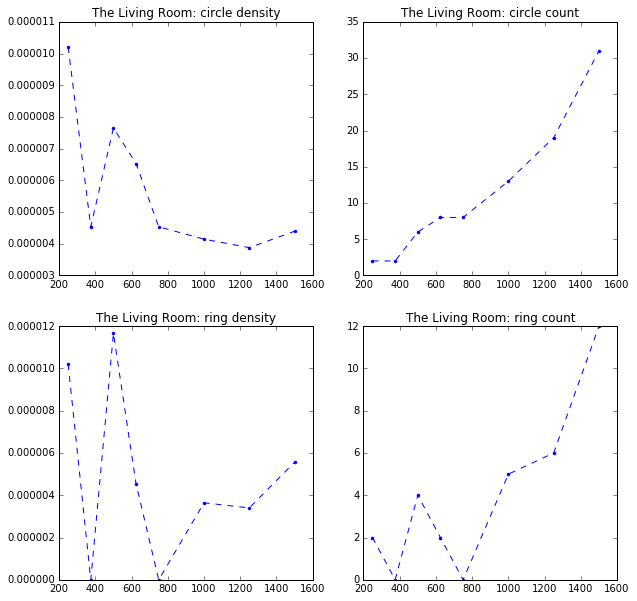

In [16]:
# # Length of 20 Blocks = 1 miles 
# => 
# 1 blocks = 0.05 mile = 0.05 $*$ 5280 feet = 264 feet 
# set Length of 1 block = 250 feet

#radius2 = [ 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]#, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
radius2 = [ 250, 375, 500, 625, 750, 1000, 1250, 1500]#, 1750, 2000, 2250, 2500]
#radius2 = np.linspace(250, 1500, 12)
#radius2=r

feet2meter(radius2)

c2_density, c2_count, c2_area, c2_density_list, c2_count_list  = circleDensity(radius2, dropin2, gdf2)
r2_density, r2_count, r2_area, r2_density_list, r2_count_list  = ringDensity(radius2, dropin2, gdf2)

print 'Ring', '\n'
print r2_count, '\n'
print r2_area, '\n'
print r2_density, '\n'
print r2_density_list, '\n'
print r2_count_list, '\n'

print 'Circle', '\n'
print c2_count, '\n'
print c2_area, '\n'
print c2_density, '\n'
print c2_density_list, '\n'
print c2_count_list, '\n'

#Plot
fig = pl.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
pl.plot(radius2, c2_density_list, '.--')
pl.title("{}: circle density".format(dropin2.Name.values[0]))
ax2 = fig.add_subplot(222)
pl.plot(radius2, c2_count_list, '.--')
pl.title("{}: circle count".format(dropin2.Name.values[0]))

ax1 = fig.add_subplot(223)
pl.plot(radius2, r2_density_list, '.--')
pl.title("{}: ring density".format(dropin2.Name.values[0]))
ax2 = fig.add_subplot(224)
pl.plot(radius2, r2_count_list, '.--')
pl.title("{}: ring count".format(dropin2.Name.values[0]))

In [17]:
fig.savefig("a")

## 4. Hypothesis Test

### CircleA V.S. CircleB

In [18]:
# 1. ring-buffer
def circles(radius, df):
    '''
    radius: list
    df: df with geometry 'Polygon'
    return: Circles not Rings, eg. b['0.001']
    '''
    b = {}
    for r in radius:
        temp = df.copy()
        temp['geometry'] = temp.buffer(r)
        temp.crs = from_epsg(4326)
        name = str(r) 
        b[name] = temp
    return b 

# 2. sjoin: (Polygon, Points) - counts
def circleSJoin(radius, b, df_points):
    '''
    b: circles (buffer)
    df_points: df with geometry "Points"
    return: Circle not Ring with # of Points in each, eg. b_sjoin['0.001']
    '''
    c_sjoin = {}
    for i, r in enumerate(b):
        name = str(radius[i])
        temp = b[name].copy()
        temp.crs = df_points.crs
        try:
            c_sjoin[name] = gpd.sjoin(temp, df_points)
        except ValueError:
            c_sjoin[name] = gpd.GeoDataFrame()
    return c_sjoin 

# 3. ringDensity
def Density(radius, circles, c_sjoin, shape):
    rAreas = {}
    rCounts = {}
    rDesity = {} 
    rCounts_list = []
    rDesity_list = []
    for i in xrange(len(radius)):
        name = str(radius[i])
        if shape == 'ring':
            pass
        elif shape == 'circle':
            rAreas[name] = circles[name].area.sum()
            if c_sjoin[name].empty:
                rCounts[name] = 0   
            else:
                rCounts[name] = c_sjoin[name].shape[0]

        rDesity[name] = rCounts[name] / rAreas[name]
        rCounts_list.append(rCounts[name])
        rDesity_list.append(rDesity[name])
    return rDesity, rCounts, rAreas, rDesity_list, rCounts_list

# 4
def ringDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'ring')
    return density, count, area, density_list, count_list  

#5
def circleDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'circle')
    return density, count, area, density_list, count_list  

#6
def feet2meter(feet):
    meter=[]
    for i in xrange(len(feet)):
        meter.append(feet[i] * 0.30480061)
    print "Feet: ", feet
    print "Meter: ", meter

In [19]:
dropin2 = dropin.copy()
gdf2 = gdf.copy()
dropin2 = dropin2.to_crs(epsg=2263) #US Feet -> 1 feet = 0.30480061 meter
gdf2 = gdf2.to_crs(epsg=2263)

radius2 = [ 250, 500, 750, 1000, 1250]

In [20]:
# Radius = 1 Blocks

r=[250] 
dropin_density = []
dropin_count = []
for i in xrange(dropin2.shape[0]):
    c_density, c_count, c_area, c_density_list, c_count_list  = circleDensity(r, dropin2.iloc[[i]], gdf2)
    dropin_density.append(c_density_list[0])
    dropin_count.append(c_count[str(r[0])])
print dropin_density,'\n', dropin_count
aa = dropin_count
a = dropin_density

[0.0006019355370052779, 1.0202297237377593e-05, 0.00013773101270459748, 1.0202297237377593e-05, 5.101148618688796e-06] 
[118, 2, 27, 2, 1]


In [21]:
# Radius = 2 Blocks
r=[500]  
dropin_density = []
dropin_count = []
for i in xrange(dropin2.shape[0]):
    c_density, c_count, c_area, c_density_list, c_count_list  = circleDensity(r, dropin2.iloc[[i]], gdf2)
    dropin_density.append(c_density_list[0])
    dropin_count.append(c_count[str(r[0])])
print dropin_density,'\n', dropin_count
bb = dropin_count
b = dropin_density

[0.00035708040330824527, 7.651722928033827e-06, 0.00012880400262190277, 6.3764357733615235e-06, 3.825861464016914e-06] 
[280, 6, 101, 5, 3]


In [22]:
stats.ttest_1samp(a,mean(b))

Ttest_1sampResult(statistic=0.45472545683544785, pvalue=0.67289188139236544)

# @ Vish: you can use this!  t-test for density of small and big circle

In [23]:
stats.ttest_rel(a,b) 

Ttest_relResult(statistic=1.0856975724613618, pvalue=0.33866580255696854)

In [24]:
print aa
print bb
diff = np.array(bb)-np.array(aa)
diff

[118, 2, 27, 2, 1]
[280, 6, 101, 5, 3]


array([162,   4,  74,   3,   2])

In [25]:
stats.ttest_1samp(aa,mean(diff))

Ttest_1sampResult(statistic=-0.8429057248658427, pvalue=0.44673384577556058)

# @ Vish: you can use this!  t-test for counts of inner circle and outer ring

In [26]:
stats.ttest_rel(aa,diff)

Ttest_relResult(statistic=-1.754302954916855, pvalue=0.15423920465948365)

### Circle V.S. NYC

In [27]:
# nyc = gpd.read_file("CT_Shape/ct_shape.shp")
# nyc2= nyc.copy()
# nyc2 = nyc2.to_crs(epsg=2263)
# nyc2_density = gdf2.shape[0] / nyc2.area.sum()
# print "The 311 Homeless Encampment Complaints Density of NYC is {:.20f}.\n\
# The Area of NYC is Around {:.3f} ft^2.\n\
# The Number of Homeless Encampment Complaints is {}.".format(nyc2_density, nyc2.area.sum(),gdf2.shape[0])

# r=[750] # 3 blocks
# dropin_density = []
# dropin_count = []
# for i in xrange(dropin2.shape[0]):
#     c_density, c_count, c_area, c_density_list, c_count_list = circleDensity(r, dropin2.iloc[[i]], gdf2)
#     dropin_density.append(c_density_list[0])
#     dropin_count.append(c_count[str(r[0])])
# print dropin_density,'\n', dropin_count

In [28]:
# stats.ttest_1samp(dropin_density, nyc2_density)

## For Each Dropin Center

#### 1. It's said that the length of 20 blocks is equal to 1 mile, which means the length of one block is around 250 feet. Thus, we set radius as np.linspace( 125, 1500, 12) -> [125, 250, 375,...] -> half block
#### 2. Plots shows the density of circle and counts of circle (and ring -> red) for each dropin center.
#### 3. However, it's impossiable to do hypo test for each dropin center like we discussed yesterday, since if we do the test for each center, the test sample size is 1 (which is meaningless). Now, we do hypo test for 5 centers, which sample size here is 5. 
#### 4. All plots are exported named as their dropin-centers' name.

In [29]:
# 1. ring-buffer
def circles(radius, df):
    '''
    radius: list
    df: df with geometry 'Polygon'
    return: Circles not Rings, eg. b['0.001']
    '''
    b = {}
    for r in radius:
        temp = df.copy()
        temp['geometry'] = temp.buffer(r)
        temp.crs = from_epsg(4326)
        name = str(r) 
        b[name] = temp
    return b 

# 2. sjoin: (Polygon, Points) - counts
def circleSJoin(radius, b, df_points):
    '''
    b: circles (buffer)
    df_points: df with geometry "Points"
    return: Circle not Ring with # of Points in each, eg. b_sjoin['0.001']
    '''
    c_sjoin = {}
    for i, r in enumerate(b):
        name = str(radius[i])
        temp = b[name].copy()
        temp.crs = df_points.crs
        c_sjoin[name] = gpd.sjoin(temp, df_points)
    return c_sjoin 

# 3. ringDensity
def Density(radius, circles, c_sjoin, shape):
    rAreas = {}
    rCounts = {}
    rDesity = {} 
    rCounts_list = []
    rDesity_list = []
    for i in xrange(len(radius)):
        name = str(radius[i])
        if shape == 'ring':
            if i == 0:
                rAreas[name] = circles[name].area.sum()
                rCounts[name] = c_sjoin[name].shape[0] 
            else:
                inside= str(radius[i-1])
                rAreas[name] = circles[name].area.sum() - circles[inside].area.sum()
                rCounts[name] = c_sjoin[name].shape[0] - c_sjoin[inside].shape[0]
        elif shape == 'circle':
            rAreas[name] = circles[name].area.sum()
            rCounts[name] = c_sjoin[name].shape[0] 
            
        rDesity[name] = rCounts[name] / rAreas[name]
        rCounts_list.append(rCounts[name])
        rDesity_list.append(rDesity[name])
    return rDesity, rCounts, rAreas, rDesity_list, rCounts_list

# 4
def ringDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'ring')
    return density, count, area, density_list, count_list  

#5
def circleDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list, count_list = Density(radius, c, bs, 'circle')
    return density, count, area, density_list, count_list  

#6
def feet2meter(feet):
    meter=[]
    for i in xrange(len(feet)):
        meter.append(feet[i] * 0.30480061)
    print "Feet: ", feet
    print "Meter: ", meter

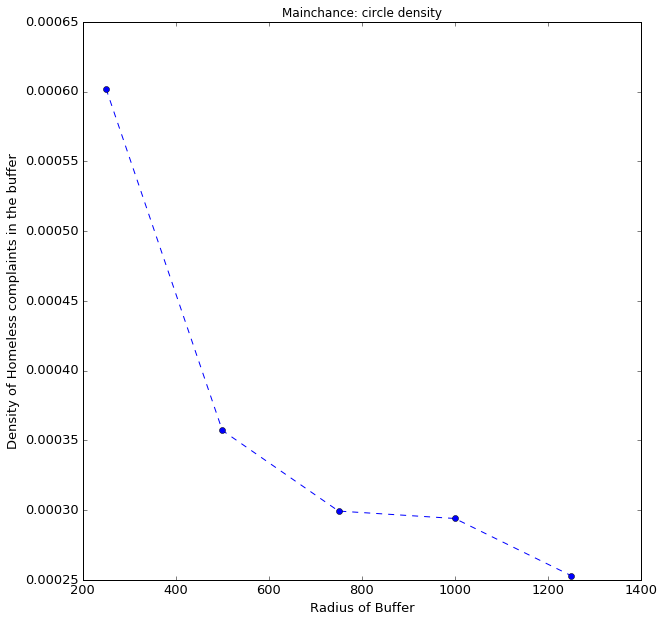

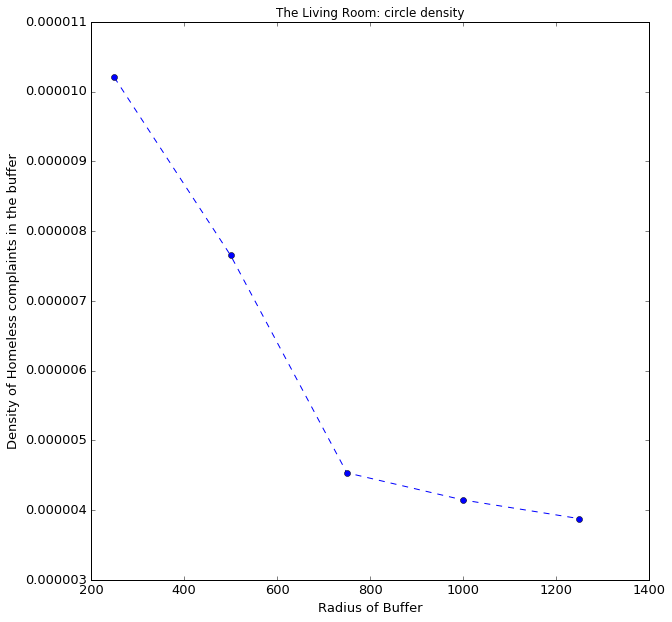

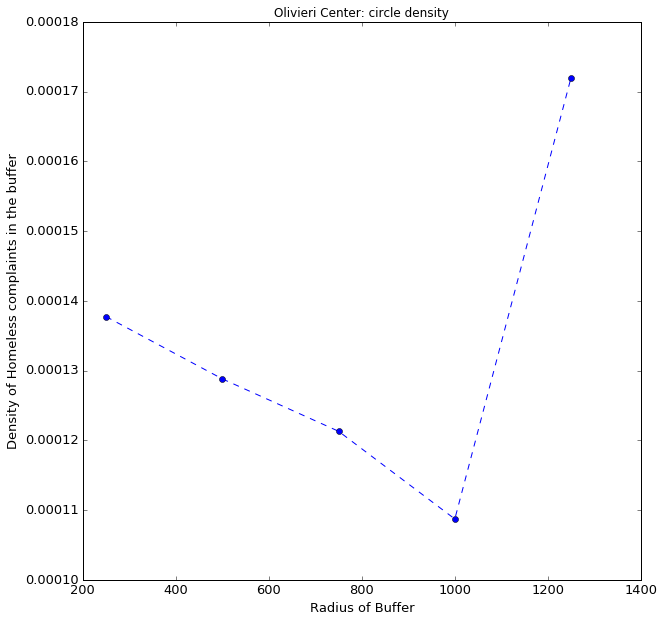

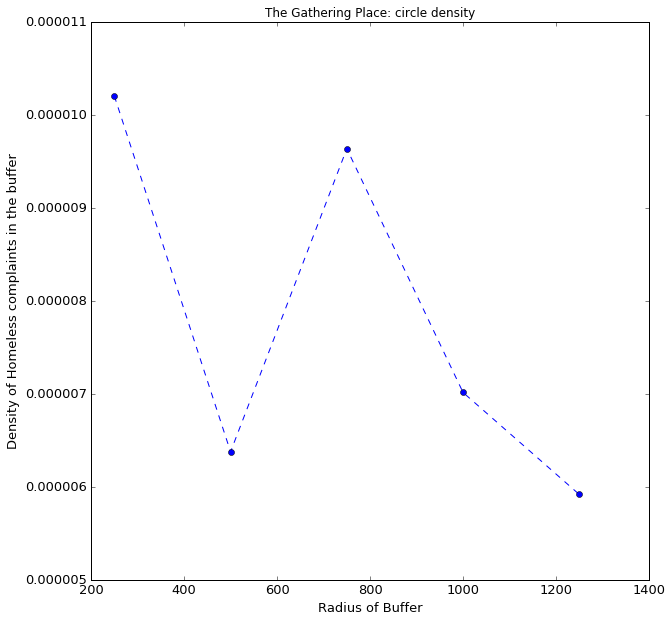

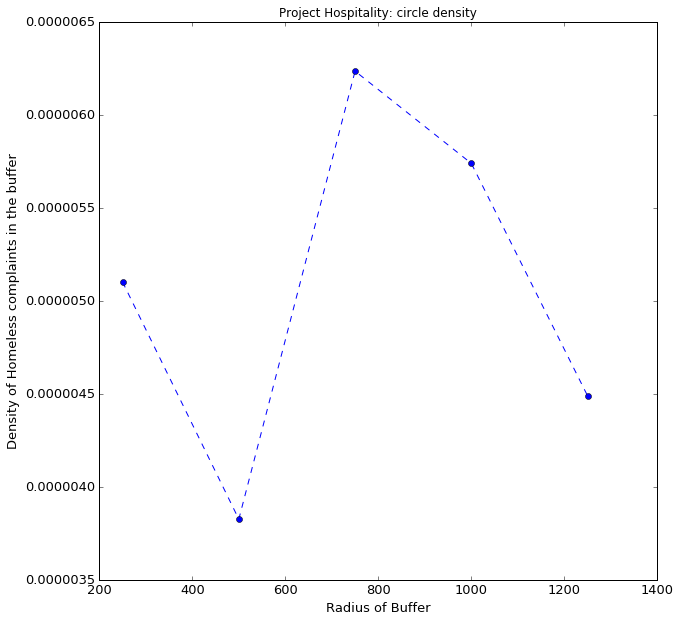

In [32]:
dropin_new = dropin.copy()
gdf2 = gdf.copy()
dropin_new = dropin_new.to_crs(epsg=2263) #US Feet -> 1 feet = 0.30480061 meter
gdf2 = gdf2.to_crs(epsg=2263)

radius2 = [ 250, 500, 750, 1000, 1250]

#feet2meter(radius2)
for i in range(5):
    dropin2 = dropin_new.ix[[i]]
    c2_density, c2_count, c2_area, c2_density_list, c2_count_list  = circleDensity(radius2, dropin2, gdf2)
    r2_density, r2_count, r2_area, r2_density_list, r2_count_list  = ringDensity(radius2, dropin2, gdf2)

    #Plot
    fig = pl.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    pl.plot(radius2, c2_density_list, 'o--')
    pl.title("{}: circle density".format(dropin2.Name.values[0]))
    pl.xlabel('Radius of Buffer', fontsize = 13)
    pl.xticks(fontsize = 13)
    pl.yticks(fontsize = 13)
    pl.ylabel('Density of Homeless complaints in the buffer', fontsize = 13)
    
#     fig = pl.figure(figsize=(10,10))
#     ax2 = fig.add_subplot(111)
#     pl.plot(radius2, c2_count_list, 'o--')
#     pl.title("{}: circle count".format(dropin2.Name.values[0]))
#     fig.savefig("{}: circle count".format(dropin2.Name.values[0]))
    
#     fig = pl.figure(figsize=(10,10))
#     ax1 = fig.add_subplot(111)
#     pl.plot(radius2, r2_density_list, 'o--')
#     pl.title("{}: ring density".format(dropin2.Name.values[0]))
#     fig.savefig("{}: ring density".format(dropin2.Name.values[0]))
    
#     fig = pl.figure(figsize=(10,10))
#     ax2 = fig.add_subplot(111)
#     pl.plot(radius2, r2_count_list, 'o--')
#     pl.title("{}: ring count".format(dropin2.Name.values[0]))
#     fig.savefig("{}: ring count".format(dropin2.Name.values[0]))
    